In [ ]:
from scipy.io import loadmat
from pandas import factorize
import pickle
import numpy as np
import random
from scipy import signal

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import os
import  imageio
import pandas as pd
import h5py
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filenames1 = ['BPSK_8PSK',  'BPSK_BPSK',  'BPSK_QPSK',  'QPSK_8PSK',  'QPSK_BPSK',  'QPSK_QPSK']
filenames2 = ['-10dB.h5', '-8dB.h5', '-6dB.h5', '-4dB.h5', '-2dB.h5', '0dB.h5',  '2dB.h5',  '4dB.h5',  '6dB.h5',  '8dB.h5', '10dB.h5',  '12dB.h5',  '14dB.h5',  '16dB.h5',  '18dB.h5', '20dB.h5']
filenames3 = ['-10dB', '-8dB', '-6dB', '-4dB', '-2dB', '0dB',  '2dB',  '4dB',  '6dB',  '8dB', '10dB',  '12dB',  '14dB',  '16dB',  '18dB', '20dB']

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
snrs = filenames3 
mods = filenames1

In [ ]:
#Extract previously uploaded data from GoogleDrive  16 SNR files for each of 6 lables
#Link to data is below, publicly accessible
#https://drive.google.com/drive/folders/1Hxcj-Jm07iRiIkN8BwelEAfOAUa_yf9Y?usp=sharing 

hdfid = h5py.File("/content/drive/MyDrive/data/"+filenames1[0]+'/'+filenames2[0], "r")
data = hdfid.get(filenames1[0]+filenames3[0])#.value # `data` is now an ndarray.
data = np.reshape(data, (2048,2,1024))

IQ = np.reshape(data, (2048,2,1024))

train_labels = []
snr_labels = []

for i in range(6):
  for j in range(16):
    hdfid = h5py.File("/content/drive/MyDrive/data/"+filenames1[i]+'/'+filenames2[j], "r")
    d = hdfid.get(filenames1[i]+filenames3[j])
    d = np.reshape(d, (2048,2,1024))
    IQ = np.concatenate((IQ, d), axis=0)
    train_labels += 2048 * [i]
    snr_labels += 2048 * [j]

In [ ]:
#Discard the set added twice with the line --> IQ = np.reshape(data, (2048,2,1024))
train_labels = to_categorical(train_labels)
IQ = IQ[2048:, :, :]
IQ.shape

(196608, 2, 1024)

In [ ]:
#Reshape the input to be competible with the data
IQ = IQ.reshape(IQ.shape[0], 1,2, 1024)
print(IQ.shape,train_labels.shape)

(196608, 1, 2, 1024) (196608, 6)


In [ ]:
#CNN Model   summury is below
tf.keras.backend.clear_session()
from tensorflow.keras import activations
model = tf.keras.Sequential()
#model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (1, 8),  strides=(1, 1),data_format = 'channels_first', padding='same', input_shape=[1, 2, 1024]))#, input_shape=[1, 2, 1024]))#argument padding='same' gives desired output here actually padding = 2 for both dircestions
model.add(layers.PReLU())
model.add(layers.Dropout(0.5))


model.add(layers.Conv2D(64, (1, 4),  strides=(1, 1), padding='same',data_format = 'channels_first'))#argument padding='same' gives desired output here actually padding = 2 for both dircestions
model.add(layers.PReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(32, (1, 2),  strides=(1, 1), padding='same',data_format = 'channels_first'))#argument padding='same' gives desired output here actually padding = 2 for both dircestions
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(256))
model.add(layers.PReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128))
model.add(layers.PReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64))
model.add(layers.PReLU())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(6))
model.add(layers.Softmax())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 2, 1024)      1152      
                                                                 
 p_re_lu (PReLU)             (None, 128, 2, 1024)      262144    
                                                                 
 dropout (Dropout)           (None, 128, 2, 1024)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 2, 1024)       32832     
                                                                 
 p_re_lu_1 (PReLU)           (None, 64, 2, 1024)       131072    
                                                                 
 dropout_1 (Dropout)         (None, 64, 2, 1024)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 2, 1024)       4

In [ ]:
#split train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(IQ, train_labels, test_size=0.25, random_state=42)

In [ ]:
del IQ #otw system crashes
batch_size =512
n_epochs =240

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "cnn_model_IQnorm.h5", save_best_only=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.05, patience=10, min_lr=0.00007),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)]
    
optimizer = keras.optimizers.Adam(learning_rate=0.0007)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=1, validation_split=0.1, callbacks=callbacks)

Epoch 1/240
260/260 [==============================] - 178s 641ms/step - loss: 1.7955 - accuracy: 0.1670 - val_loss: 1.7919 - val_accuracy: 0.1659 - lr: 7.0000e-04
Epoch 2/240
260/260 [==============================] - 165s 633ms/step - loss: 1.7919 - accuracy: 0.1666 - val_loss: 1.7918 - val_accuracy: 0.1649 - lr: 7.0000e-04
Epoch 3/240
260/260 [==============================] - 165s 633ms/step - loss: 1.7918 - accuracy: 0.1673 - val_loss: 1.7918 - val_accuracy: 0.1664 - lr: 7.0000e-04
Epoch 4/240
260/260 [==============================] - 164s 631ms/step - loss: 1.7918 - accuracy: 0.1673 - val_loss: 1.7918 - val_accuracy: 0.1650 - lr: 7.0000e-04
Epoch 5/240
260/260 [==============================] - 165s 635ms/step - loss: 1.7918 - accuracy: 0.1683 - val_loss: 1.7918 - val_accuracy: 0.1653 - lr: 7.0000e-04
Epoch 6/240
260/260 [==============================] - 164s 631ms/step - loss: 1.7918 - accuracy: 0.1682 - val_loss: 1.7918 - val_accuracy: 0.1649 - lr: 7.0000e-04
Epoch 7/240
260/

In [ ]:
model.save("IQ_mode_classification2.h5") #save an extra h5 in case missing model in history

In [ ]:
model = keras.models.load_model("IQ_mode_classification2.h5")## accuracy around 0.92

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

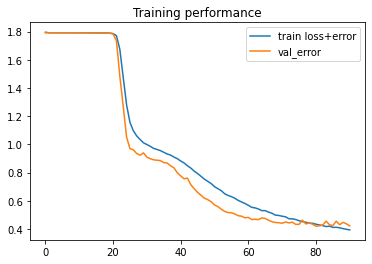

In [ ]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
#define plot size
plt.figure(figsize=(12,8))
markers_on = [0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15]
#create plot of x and y
plt.plot(snrs, acc,'-gD', markevery=markers_on, label='Classification Accuracy')
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN Classification Accuracy")
plt.grid()
plt.legend()
plt.show()

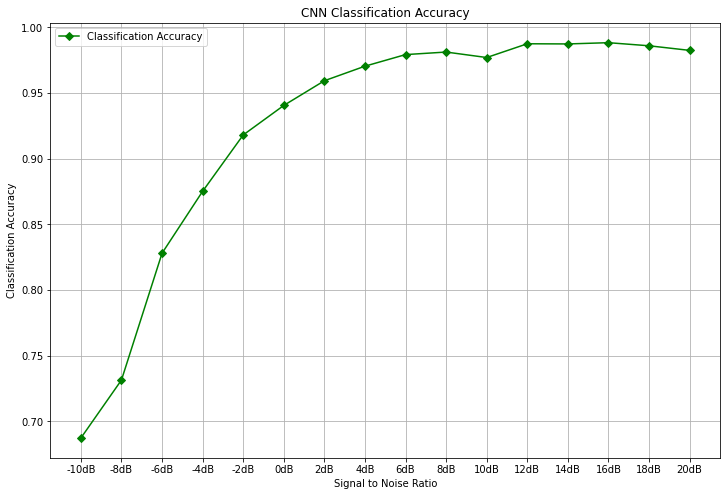

In [ ]:
from sklearn.metrics import accuracy_score

       Accuracy at -10dB SNR level =  0.6872659176029963


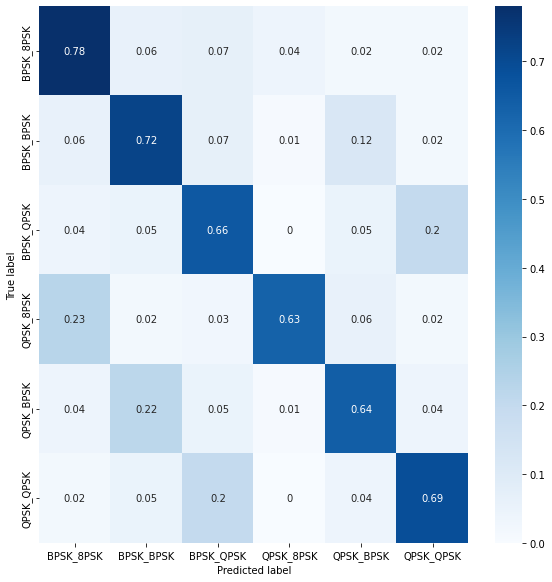

       Accuracy at -8dB SNR level =  0.7314207650273225


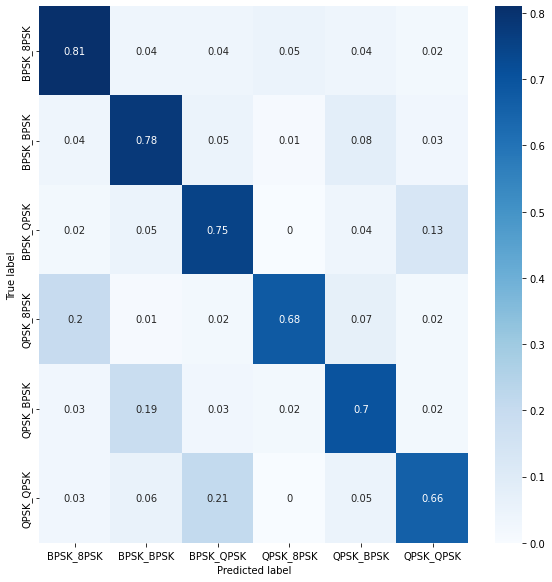

       Accuracy at -6dB SNR level =  0.827972027972028


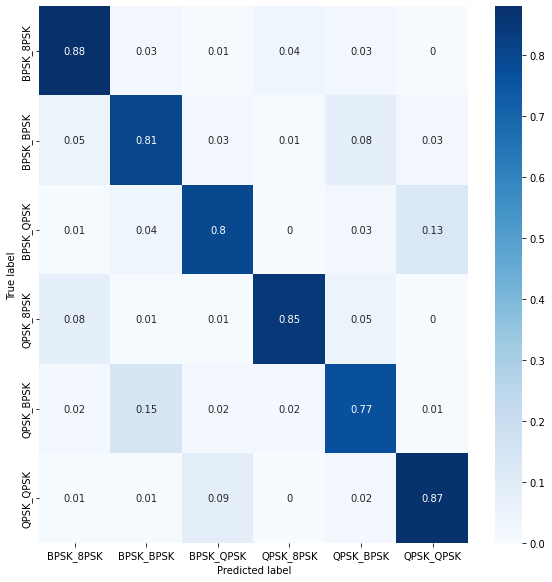

       Accuracy at -4dB SNR level =  0.875101598482796


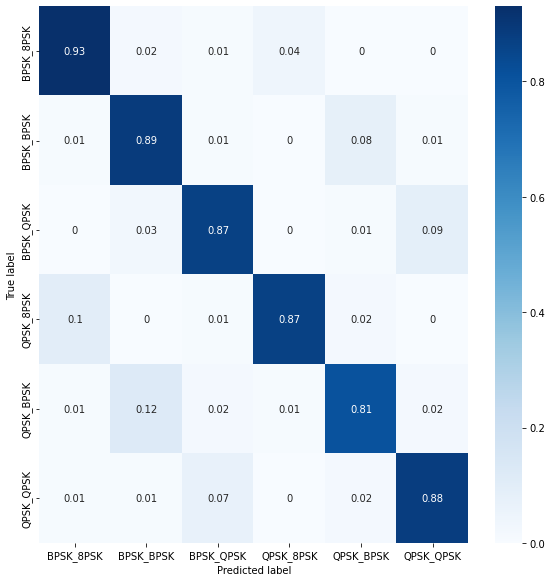

       Accuracy at -2dB SNR level =  0.9180059929174612


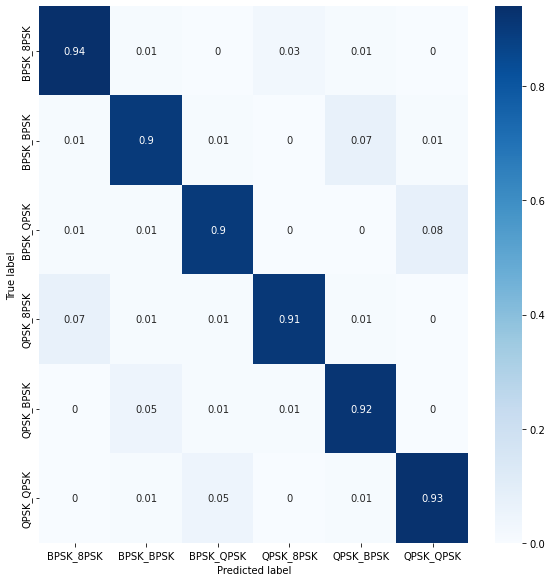

       Accuracy at 0dB SNR level =  0.9404698344901228


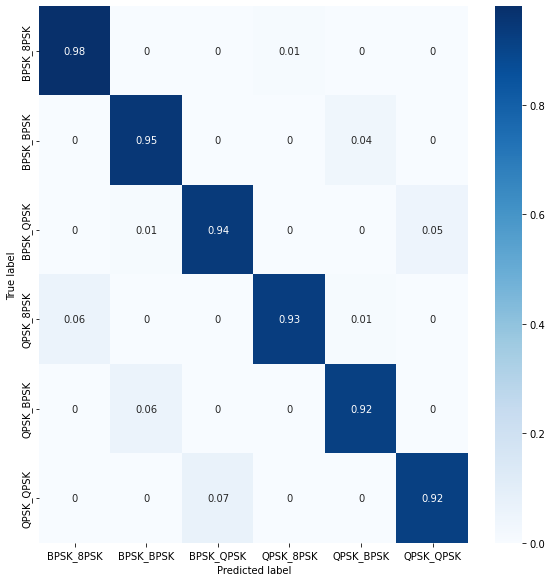

       Accuracy at 2dB SNR level =  0.9592723323377681


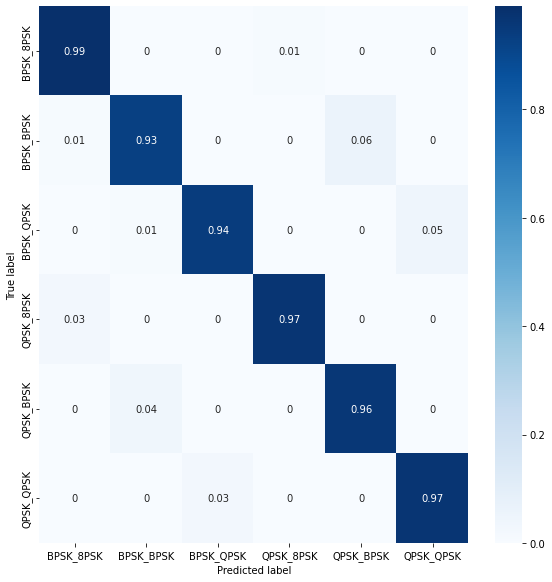

       Accuracy at 4dB SNR level =  0.9703562686973076


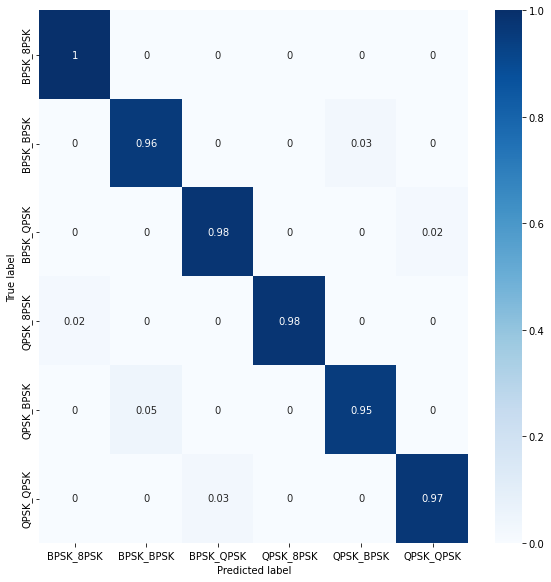

       Accuracy at 6dB SNR level =  0.9791779340183883


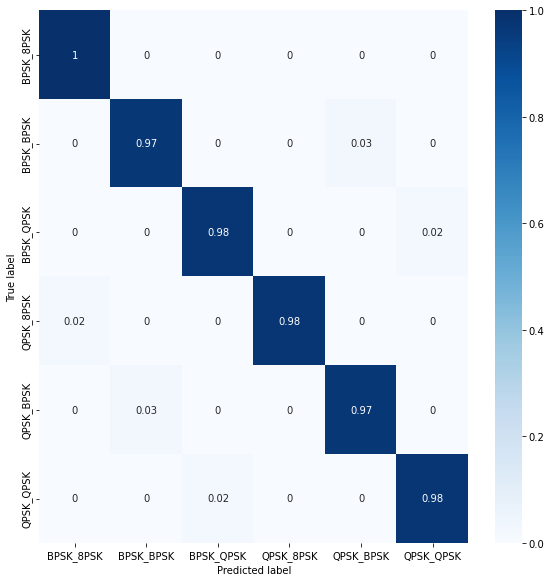

       Accuracy at 8dB SNR level =  0.9811170212765957


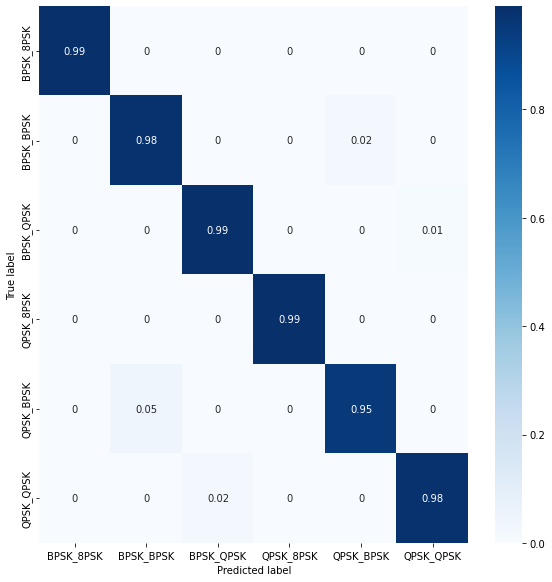

       Accuracy at 10dB SNR level =  0.9769484083424808


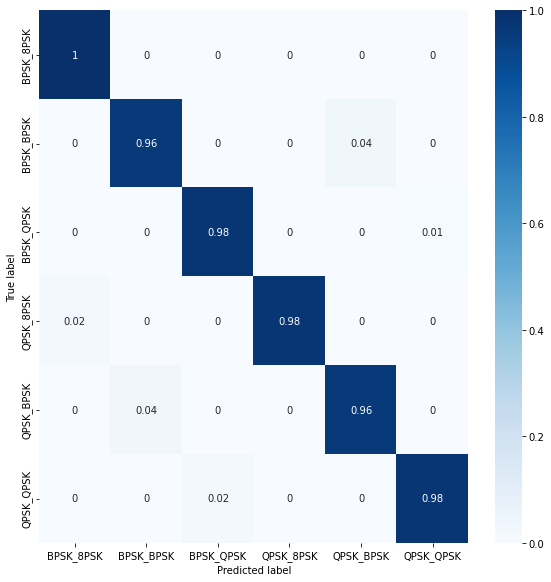

       Accuracy at 12dB SNR level =  0.9874248223072717


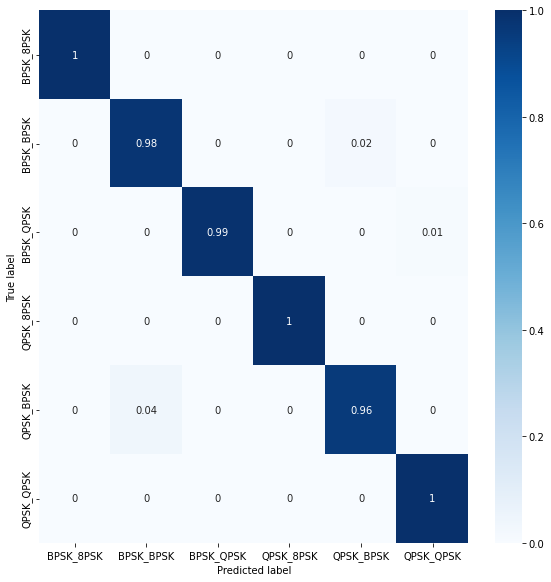

       Accuracy at 14dB SNR level =  0.987292817679558


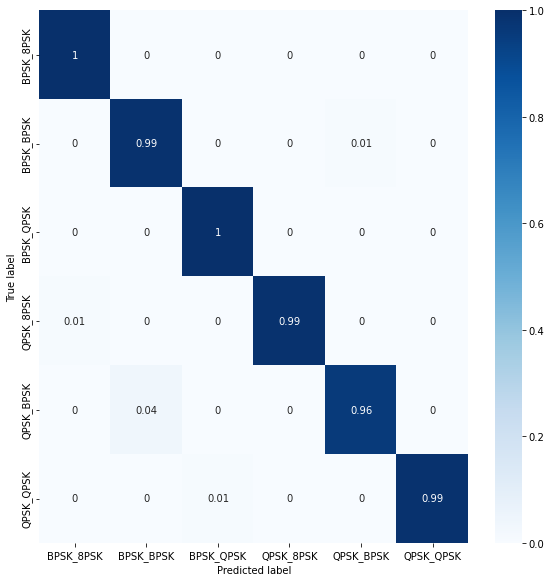

       Accuracy at 16dB SNR level =  0.9882449425915801


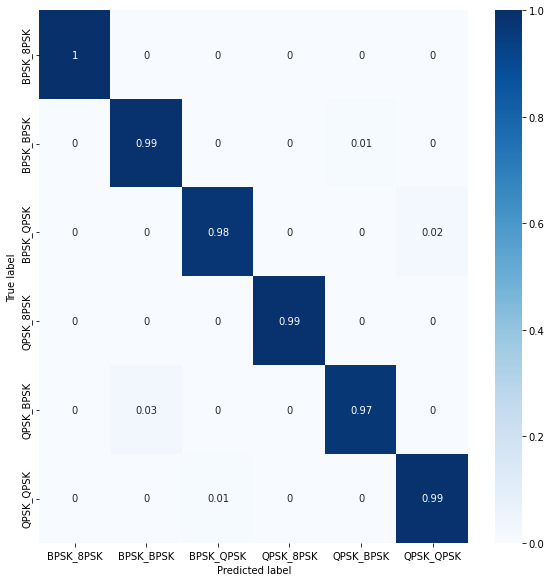

       Accuracy at 18dB SNR level =  0.9858892438764644


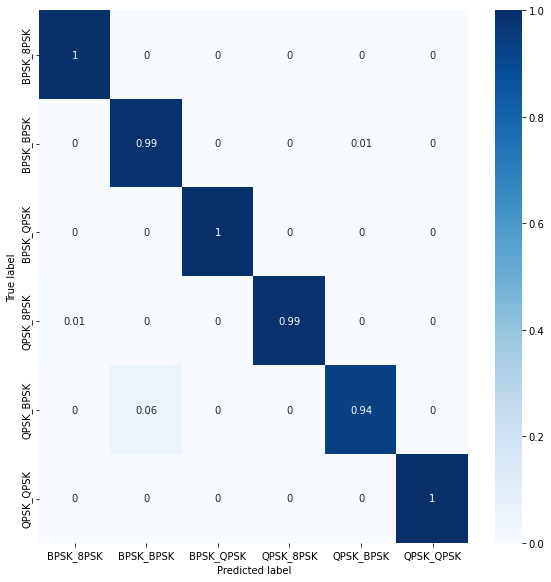

       Accuracy at 20dB SNR level =  0.9823906083244397


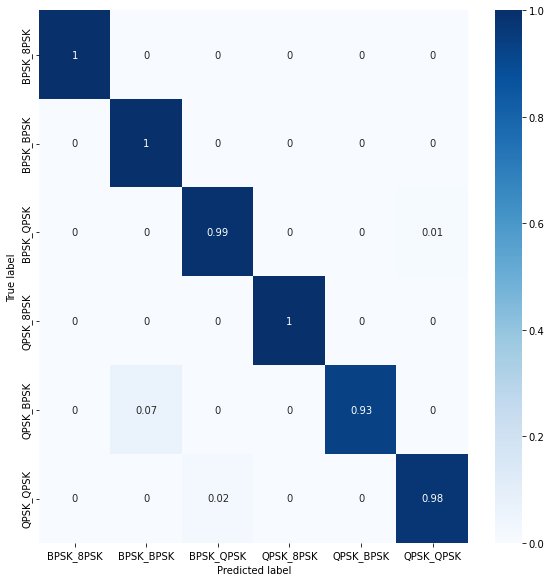

In [ ]:
# Plot confusion matrix
acc = []
tot_acc = []

for snr in snrs:
  test_X_i = X_test[np.where(y_test == str(snr))]
  test_Y_i = y_test[np.where(y_test == str(snr))] 
  y_pred = model.predict(test_X_i, batch_size=512)
  
  test_Y_i = np.argmax(test_Y_i, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  accuracy = accuracy_score(test_Y_i, y_pred)
  acc.append(accuracy)

  print("       Accuracy at "+ snr + " SNR level = ",accuracy)

  test_Y_i_tot = np.concatenate((test_Y_i_tot, test_Y_i), axis=0)
  y_pred_tot = np.concatenate((y_pred_tot, y_pred), axis=0)


  con_mat = tf.math.confusion_matrix(labels=test_Y_i, predictions=y_pred).numpy()
  figure = plt.figure(figsize=(8, 8))

  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat_norm,
                     index = mods, 
                     columns = mods)


  sns.heatmap(con_mat_df , annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()



  #plt.figure()
  #plot_confusion_matrix(conf, labels=mods, title="CNN Confusion Matrix (SNR=%s)"%(snr))

         Accuracy  for the whole SNR =  0.9237576928945629


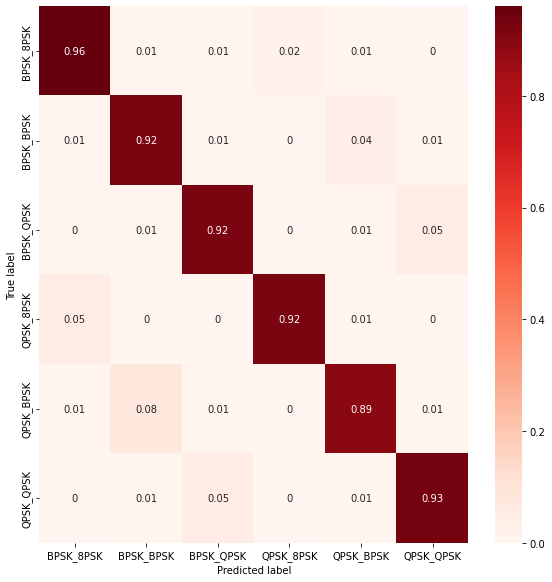

In [ ]:
print("         Accuracy  for the whole SNR"" = ",accuracy)


con_mat = tf.math.confusion_matrix(labels=test_Y_i, predictions=y_pred).numpy()
figure = plt.figure(figsize=(8, 8))

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = mods, 
                     columns = mods)


sns.heatmap(con_mat_df , annot=True,cmap=plt.cm.Reds)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()